## Import packages

In [1]:
#import the models and plotting tools

import numpy as np
import matplotlib.pyplot as plt
from lmfit.models import PseudoVoigtModel  ##error: No module named 'lmfit'
from lmfit import Model
from lmfit.parameter import Parameters
from ipywidgets import FloatProgress
from IPython.display import display
from pathlib import Path
from scipy.signal import medfilt
import glob, os

import time
import os
import pickle

#import diamond_functions as dia
from diamond_functions import *

#for graphs inline with the text on mac and widows...
%matplotlib inline
#for interactive graphs inline with the text on mac and widows...
#%matplotlib interactive
#best for pop-out graphs on windows...
#%matplotlib tk
#best for pop-out graphs on mac...
# %matplotlib
#for pop-out graphs on mac and windows, but it's a bit dodgey...
#%matplotlib qt

## Adjusting plot parameters

In [2]:
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rc('legend',fontsize=20)
plt.rc('axes',linewidth=2)
plt.rc('xtick.major',width=2,size=10)
plt.rc('xtick.minor', width=2, size=5)
plt.rc('ytick.major',width=2,size=10)
plt.rc('ytick.minor',width=2,size=5)

## Define directory & fileprefix:

In [3]:
base_dir= r'C:\Users\mbgnwob2\Dropbox (The University of Manchester)\2. Project\Python Script\Single Peak Fitting Script ORIGINAL - Copy'
pickles_dir = base_dir + '\All_pickles'
out_dir = base_dir + '\All_pickles\Plots'
pickle_ftype = '\*.pickle'

print('Pickle files directory = ' + pickles_dir)
print('Output folder is: ' + out_dir)

Pickle files directory = C:\Users\mbgnwob2\Dropbox (The University of Manchester)\2. Project\Python Script\Single Peak Fitting Script ORIGINAL - Copy\All_pickles
Output folder is: C:\Users\mbgnwob2\Dropbox (The University of Manchester)\2. Project\Python Script\Single Peak Fitting Script ORIGINAL - Copy\All_pickles\Plots


## Load a data file

Enter which peak file you wish to analyse:

Text(0.5, 1.0, 'Sample 2')

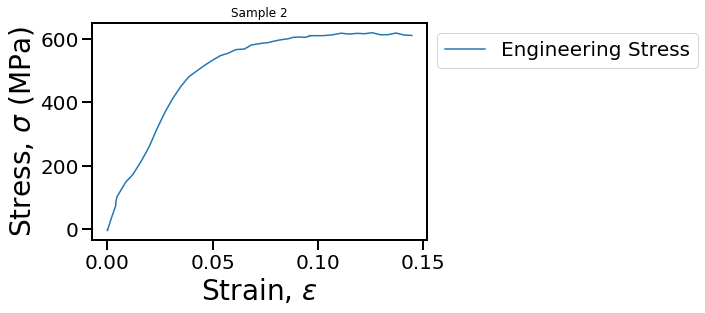

In [4]:
## Load mechanical data from file
Eng_stress = np.loadtxt(base_dir + '\Stress_strain_Tension_Samp2.txt', usecols=0)
Eng_stress = Eng_stress[:-1]
Eng_strain = np.loadtxt(base_dir + '\Stress_strain_Tension_Samp2.txt', usecols=1)
Eng_strain = Eng_strain[:-1]
plt.plot(Eng_strain, Eng_stress, label = 'Engineering Stress')
plt.legend(loc=2, bbox_to_anchor=(1, 1))
plt.ylabel('Stress, $\sigma$ (MPa)', fontsize=28)
plt.xlabel('Strain, ${\epsilon}$', fontsize=28)
plt.title('Sample 2')

In [5]:
## Load in all intensity files and chack how many exist ##update location required
dicts = glob.glob(pickles_dir + pickle_ftype)
num_dicts=len(dicts)
dics_list = list(dicts)


print('Number of files in dir = ', num_dicts)
dic_names = []
for i in dics_list:
    x = (i.split('\\')[-1])
    dic_names.append(x)
print('Length of names list: ', len(dic_names))
for i in dic_names:
    print(i)

Number of files in dir =  18
Length of names list:  18
16_(01-10) & (111).pickle
16_(220) & (11-20).pickle
16_(311) & (02-20).pickle
18_(01-10) & (111).pickle
18_(220) & (11-20).pickle
18_(311) & (02-20).pickle
19_(01-10) & (111).pickle
19_(220) & (11-20).pickle
19_(311) & (02-20).pickle
1_(01-10) & (111).pickle
1_(220) & (11-20).pickle
1_(311) & (20-20).pickle
24_(01-10) & (111).pickle
24_(220) & (11-20).pickle
28_(01-10) & (111).pickle
28_(220) & (11-20).pickle
9_(01-10) & (111).pickle
9_(220) & (11-20).pickle


In [6]:
list_matrix_peaks = []
list_matrix_peak_centers = []
list_matrix_peak_fwhm = []
list_matrix_peak_amplitude = []

list_ZrH_peaks = []
list_ZrH_peak_centres = []
list_ZrH_peak_fwhm = []
list_ZrH_peak_amplitude = []

In [7]:
for pickles in dic_names:
    with open(pickles_dir + '\\' + pickles, 'rb') as x:
        data = pickle.load(x)
    
    #enter names of reflections in dictionary you intend to analyse
    reflections=pickles[pickles.find('('):-7]
    cake = pickles.split('_')[0]
        
    # Seperate reflections from a filename
    def find(ch,string1):
        pos = []
        for i in range(len(string1)):
            if ch == string1[i]:
                pos.append(i)
        return(pos)

    allpeaks = []
    for i,j in zip(find('(', pickles), find(')', pickles)):
        allpeaks.append(pickles[i:j+1])
        
    numpeaks=len(allpeaks)
    print('Reflections: {0}'.format(reflections), '\tCake =', cake, '\tPeaks in Pickle =', numpeaks, '\t', allpeaks)

### Extracting peak centres

    firstFile = 0
    lastFile = len(data)
    #print('Number of Strain Steps: {0}'.format(lastFile))
    step = 1

### isolate hydride reflections
    
    #n = number of reflections in peak_list, peak will be the reflections in the peak_list
    for n, peak in enumerate(allpeaks):
        
        #set up dictionaries to store the peak information
        m_peak_centres={}
        m_peak_fwhm={}
        m_peak_amplitude={}    
        ZrH_peak_centres={}
        ZrH_peak_fwhm={}
        ZrH_peak_amplitude={}
        
        if len(peak) > 5:
            m_peak_centres[peak]=[]
            m_peak_fwhm[peak]=[]
            m_peak_amplitude[peak]=[]
        
        if len(peak) <= 5:
            ZrH_peak_centres[peak]=[]
            ZrH_peak_fwhm[peak]=[]
            ZrH_peak_amplitude[peak]=[]


        image_number=[]
        
#### Modify list length so data has required shape ###
        
        for i in range(len(data)-1):
            
            if numpeaks > 1:
                prefix = 'pv_' + str(n+1)
            if numpeaks == 1:
                prefix = ''
            
            if len(peak) <= 5:
                
                ttheta = data[i][reflections]['params_values'][prefix + 'center']
                ZrH_peak_centres[peak].append(ttheta)
                
                ttheta = data[i][reflections]['params_values'][prefix + 'amplitude']
                ZrH_peak_amplitude[peak].append(ttheta)
                
                ttheta = data[i][reflections]['params_values'][prefix + 'fwhm']
                ZrH_peak_fwhm[peak].append(ttheta)


            
            if len(peak) > 5:
                ttheta = data[i][reflections]['params_values'][prefix + 'center']
                m_peak_centres[peak].append(ttheta)
                
                ttheta = data[i][reflections]['params_values'][prefix + 'amplitude']
                m_peak_amplitude[peak].append(ttheta)
                
                ttheta = data[i][reflections]['params_values'][prefix + 'fwhm']
                m_peak_fwhm[peak].append(ttheta)
        
        #print(peak_centres[reflection])

        if len(peak) <= 5:

            list_ZrH_peaks.append(cake + '_' + peak)

            x = list(ZrH_peak_centres.values())[0]
            fwhm = list(ZrH_peak_fwhm.values())[0]
            amp = list(ZrH_peak_amplitude.values())[0]
            if len(list(ZrH_peak_centres.values())) > 1:
                raise Exception
            list_ZrH_peak_centres.append(x)
            list_ZrH_peak_fwhm.append(fwhm)
            list_ZrH_peak_amplitude.append(amp)


        else:
            
            list_matrix_peaks.append(cake + '_' + peak)
            
            y = list(m_peak_centres.values())[0]
            m_fwhm = list(m_peak_fwhm.values())[0]
            m_amp = list(m_peak_amplitude.values())[0]
            list_matrix_peak_centers.append(y)           
            list_matrix_peak_fwhm.append(m_fwhm)
            list_matrix_peak_amplitude.append(m_amp)

Reflections: (01-10) & (111) 	Cake = 16 	Peaks in Pickle = 2 	 ['(01-10)', '(111)']
Reflections: (220) & (11-20) 	Cake = 16 	Peaks in Pickle = 2 	 ['(220)', '(11-20)']
Reflections: (311) & (02-20) 	Cake = 16 	Peaks in Pickle = 2 	 ['(311)', '(02-20)']
Reflections: (01-10) & (111) 	Cake = 18 	Peaks in Pickle = 2 	 ['(01-10)', '(111)']
Reflections: (220) & (11-20) 	Cake = 18 	Peaks in Pickle = 2 	 ['(220)', '(11-20)']
Reflections: (311) & (02-20) 	Cake = 18 	Peaks in Pickle = 2 	 ['(311)', '(02-20)']
Reflections: (01-10) & (111) 	Cake = 19 	Peaks in Pickle = 2 	 ['(01-10)', '(111)']
Reflections: (220) & (11-20) 	Cake = 19 	Peaks in Pickle = 2 	 ['(220)', '(11-20)']
Reflections: (311) & (02-20) 	Cake = 19 	Peaks in Pickle = 2 	 ['(311)', '(02-20)']
Reflections: (01-10) & (111) 	Cake = 1 	Peaks in Pickle = 2 	 ['(01-10)', '(111)']
Reflections: (220) & (11-20) 	Cake = 1 	Peaks in Pickle = 2 	 ['(220)', '(11-20)']
Reflections: (311) & (20-20) 	Cake = 1 	Peaks in Pickle = 2 	 ['(311)', '(20-2

In [8]:
print(len(list_matrix_peaks))
print(len(list_ZrH_peaks))

print('Number of pickle files = {}'.format(len(list_matrix_peak_centers)),'\nNumber of steps = {}'.format(len(list_matrix_peak_centers[0])))
x = len(list_matrix_peak_centers)*len(list_matrix_peak_centers[0])

18
18
Number of pickle files = 18 
Number of steps = 58


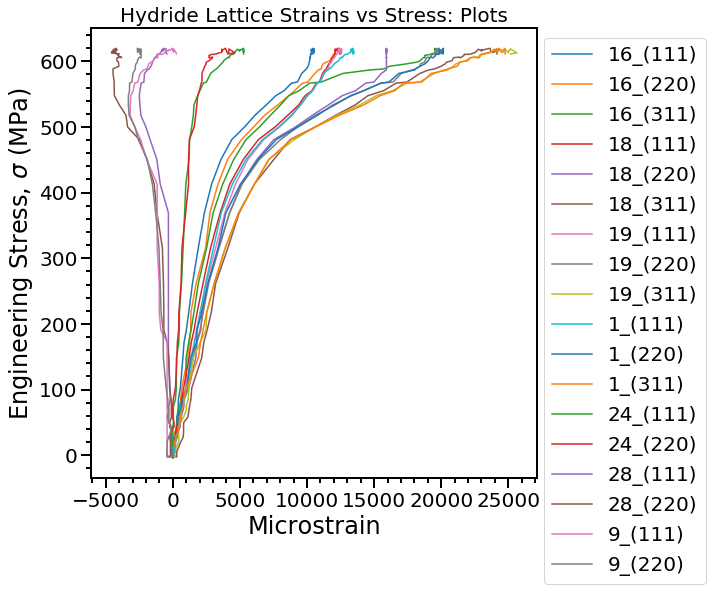

In [9]:
plt.figure(figsize=(10,8))
plt.minorticks_on()
    
for i, j in zip(list_ZrH_peak_centres, list_ZrH_peaks):
    L_strain=calc_strain_singlepoint(i)*1e6

    plt.plot(medfilt(L_strain, 3), Eng_stress, markersize=8,label=j)
    plt.legend(loc=1, bbox_to_anchor=(1.4, 1))
    plt.title('Hydride Lattice Strains vs Stress: ' + out_dir.split('\\')[8].split('_')[0],fontsize=20)
    plt.ylabel('Engineering Stress, ${\sigma}$ (MPa)', fontsize=24)
    plt.xlabel('Microstrain',fontsize=24)

    plt.tight_layout()
    plot_name='\All Hydride Lattice Strains vs Stress'
    plt.savefig(out_dir + plot_name , bbox_inches='tight')



In [ ]:
plt.figure(figsize=(10,8))
plt.minorticks_on()
    
for i, j in zip(list_matrix_peak_centers, list_matrix_peaks):
    L_strain=calc_strain_singlepoint(i)*1e6

    plt.plot(L_strain, Eng_stress, markersize=8,label=j)
    plt.legend(loc=1, bbox_to_anchor=(1.4, 1))
    plt.title('Matrix Lattice Strains vs Stress: ' + out_dir.split('\\')[8].split('_')[0],fontsize=20)
    plt.ylabel('Engineering Stress, ${\sigma}$ (MPa)', fontsize=24)
    plt.xlabel('Microstrain',fontsize=24)

    plt.tight_layout()
    plot_name = '\All Matrix Lattice Strains vs Stress'
    plt.savefig(out_dir + plot_name, bbox_inches='tight')

In [ ]:
plt.figure(figsize=(10,8))
plt.minorticks_on()
    
for i, j in zip(list_ZrH_peak_amplitude, list_ZrH_peaks):
    plt.plot(Eng_stress,medfilt(i, 3),markersize=8,label=j)
    plt.legend(loc=1, bbox_to_anchor=(1.4, 1))
    plt.title('Hydride Peak Area vs Stress: ' + out_dir.split('\\')[8].split('_')[0],fontsize=20)
    plt.xlabel('Engineering Stress, ${\sigma}$', fontsize=24)
    plt.ylabel('Peak Area',fontsize=24)

    plt.tight_layout()
    plot_name='\All Hydride Area Changes vs Stress'
    plt.savefig(out_dir + plot_name , bbox_inches='tight')

In [ ]:
plt.figure(figsize=(10,8))
plt.minorticks_on()
    
for i, j in zip(list_matrix_peak_amplitude, list_matrix_peaks):
    plt.plot(Eng_strain,medfilt(i, 3),markersize=8,label=j)
    plt.legend(loc=1, bbox_to_anchor=(1.4, 1))
    plt.title('Matrix Peak Area: ' + out_dir.split('\\')[8].split('_')[0],fontsize=24)
    plt.xlabel('Engineering Strain, ${\epsilon}$', fontsize=24)
    plt.ylabel('Peak Area',fontsize=24)

    plt.tight_layout()
    plot_name='\All Matrix Area Changes'
    plt.savefig(out_dir + plot_name , bbox_inches='tight')

In [ ]:
plt.figure(figsize=(10,8))
plt.minorticks_on()
    
for i, j in zip(list_ZrH_peak_fwhm, list_ZrH_peaks):
    plt.plot(Eng_stress, medfilt(i, 3), markersize=8,label=j)
    plt.legend(loc=1, bbox_to_anchor=(1.4, 1))
    plt.title('Hydride Peak FWHM: ' + out_dir.split('\\')[8].split('_')[0],fontsize=24)
    plt.xlabel('Engineering Stress, ${\sigma}$', fontsize=24)
    plt.ylabel('FWHM',fontsize=24)

    plt.tight_layout()
    plot_name='\All Hydride FWHM Changes'
    plt.savefig(out_dir + plot_name , bbox_inches='tight')

In [ ]:
plt.figure(figsize=(10,8))
plt.minorticks_on()
    
for i, j in zip(list_matrix_peak_fwhm, list_matrix_peaks):
    plt.plot(Eng_stress,medfilt(i, 3),markersize=8,label=j)
    plt.legend(loc=1, bbox_to_anchor=(1.4, 1))
    plt.title('Matrix Peak FWHM: ' + out_dir.split('\\')[8].split('_')[0],fontsize=24)
    plt.xlabel('Engineering Stress, ${\sigma}$', fontsize=24)
    plt.ylabel('FWHM',fontsize=24)

    plt.tight_layout()
    plot_name='\All Matrix FWHM Changes'
    plt.savefig(out_dir + plot_name , bbox_inches='tight')

In [9]:
import math
import matplotlib.patches as mpatches

In [10]:
pi = math.pi

pp_range = np.arange(0, (2*pi), ((2*pi)/36))
print(pp_range)
pp_range_deg = pp_range*(180/pi)
print(pp_range_deg)

[0.         0.17453293 0.34906585 0.52359878 0.6981317  0.87266463
 1.04719755 1.22173048 1.3962634  1.57079633 1.74532925 1.91986218
 2.0943951  2.26892803 2.44346095 2.61799388 2.7925268  2.96705973
 3.14159265 3.31612558 3.4906585  3.66519143 3.83972435 4.01425728
 4.1887902  4.36332313 4.53785606 4.71238898 4.88692191 5.06145483
 5.23598776 5.41052068 5.58505361 5.75958653 5.93411946 6.10865238]
[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150. 160. 170. 180. 190. 200. 210. 220. 230. 240. 250. 260. 270.
 280. 290. 300. 310. 320. 330. 340. 350.]


In [83]:
#list_matrix_peaks 
#list_matrix_peak_centers
#list_matrix_peak_fwhm
#list_matrix_peak_amplitude 

#list_ZrH_peaks 
#list_ZrH_peak_centres 
#list_ZrH_peak_fwhm 
#list_ZrH_peak_amplitude 
print(list_ZrH_peaks)
print(len(list_ZrH_peak_centres))

['16_(111)', '16_(220)', '16_(311)', '18_(111)', '18_(220)', '18_(311)', '19_(111)', '19_(220)', '19_(311)', '1_(111)', '1_(220)', '1_(311)', '24_(111)', '24_(220)', '28_(111)', '28_(220)', '9_(111)', '9_(220)']
18


In [89]:
##re-arrange data into format: [peak][cake][step]


pk_names = ['111', '220', '311']

peak_cake_pos = []
peak_centres = []

for i in pk_names:
    new_list = []
    new_list2 = []
    for j, k in zip(list_ZrH_peaks, list_ZrH_peak_centres):
        if i in j:
            new_list.append(j.split('_')[0]) # append name 'cake_peak'
            new_list2.append(k) #append list of centres
    peak_cake_pos.append(new_list) #list of 'cake value' for peaks
    peak_centres.append(new_list2) #list of data matching shape of list: peak_cake_pos
    
print(peak_cake_pos)

#q[peak][cake][step]
print(len(peak_centres), len(peak_centres[0]), len(peak_centres[0][0]))

[['16', '18', '19', '1', '24', '28', '9'], ['16', '18', '19', '1', '24', '28', '9'], ['16', '18', '19', '1']]
3 7 58


In [91]:
strain_peak_111_C0 = calc_strain_singlepoint(peak_centres[0][0])*1e6
print(len(strain_peak_111_C0), '\n', strain_peak_111_C0)

58 
 [   -0.           -46.37509118   -21.58677727   -26.52949037
    24.13509984    72.4631645    143.89307194   153.78905253
   259.64403568   266.64522095   299.33002689   307.80064722
   382.55136374   405.93004315   413.93760938   561.31058052
   751.5037333    838.09850071  1010.88535882  1186.57668227
  1468.91915831  1902.22819104  2353.71529987  2891.87397077
  3591.35232002  4395.83424685  5346.06638342  6110.96949748
  6951.46693645  7673.8788082   8291.94710264  8845.79962956
  9289.4374843   9605.19401753  9876.63769819  9957.89108454
 10084.97749917 10139.3526416  10163.60206085 10216.38320145
 10202.33497085 10232.75526159 10271.48239169 10235.71970416
 10295.62363031 10251.01789944 10321.857896   10317.59120052
 10340.45639467 10311.45557103 10460.66246003 10425.44592458
 10448.48322829 10442.71828781 10530.29518922 10516.36352477
 10389.50883331 10525.36987542]


In [141]:
## convert peak centres into strains
##format: [peak][cake][step]
print('Num peaks = ', len(peak_centres))
print('Num cakes = ', len(peak_centres[0]))
print('Num steps = ', len(peak_centres[0][0]), '\n')

peak_strains = []

for peak in range(len(peak_centres)):
    print('\n "peak" iterable val = ', peak, '\n')
    new_list = []
    peak_strains.append(new_list)
    print('errrr.... current size of peak_strains list =', len(peak_strains), '\n')

    for cake in range(len(peak_centres[peak])):
        print('"cake" iterable val = ', cake)
        
        tmp = []
        peak_strains[peak].append(tmp) #should create 7 lists within peak_strains[0]
        
        L_strain = calc_strain_singlepoint(peak_centres[peak][cake])*1e6
        L_strain = L_strain.tolist()
        for strain in L_strain:
            peak_strains[peak][cake].append(strain)
        
print('\n\n', len(peak_strains), len(peak_strains[0]), len(peak_strains[0][0]),'\n', peak_strains[0][0])

Num peaks =  3
Num cakes =  7
Num steps =  58 


 "peak" iterable val =  0 

errrr.... current size of peak_strains list = 1 

"cake" iterable val =  0
"cake" iterable val =  1
"cake" iterable val =  2
"cake" iterable val =  3
"cake" iterable val =  4
"cake" iterable val =  5
"cake" iterable val =  6

 "peak" iterable val =  1 

errrr.... current size of peak_strains list = 2 

"cake" iterable val =  0
"cake" iterable val =  1
"cake" iterable val =  2
"cake" iterable val =  3
"cake" iterable val =  4
"cake" iterable val =  5
"cake" iterable val =  6

 "peak" iterable val =  2 

errrr.... current size of peak_strains list = 3 

"cake" iterable val =  0
"cake" iterable val =  1
"cake" iterable val =  2
"cake" iterable val =  3


 3 7 58 
 [-0.0, -46.37509117903771, -21.586777273871412, -26.529490367945332, 24.135099841071135, 72.46316450456594, 143.8930719388874, 153.78905253070744, 259.64403568257035, 266.64522095135806, 299.3300268889668, 307.8006472239711, 382.55136373867896, 405.9300

In [142]:
##format: [peak][cake][step]

full_list0 = []
full_list1 = []
full_list2 = []
strains_list = []
N = 58

#Creat list of 36 lists
for i in range(0,36):
    i = []
    full_list0.append(i)
    full_list1.append(i)
    full_list2.append(i)
    
##replace element in full_list'x' with data from 'q' in correctly indexed location
    
for index, replacement in zip(peak_cake_pos[0], peak_strains[0]):
    index = int(index)-1
    full_list0[index] = replacement

## pad all empty lists within full_list'x'
pad_list0 = []

for i in full_list0:
    i += [0] * (N - len(i))
    pad_list0.append(i)

##repeat for next list    
for index, replacement in zip(peak_cake_pos[1], peak_strains[1]):
    index = int(index)-1
    full_list1[index] = replacement
    
pad_list1 = []
    
for i in full_list1:
    i += [0] * (N - len(i))
    pad_list1.append(i)

    
for index, replacement in zip(peak_cake_pos[2], peak_strains[2]):
    index = int(index)-1
    full_list2[index] = replacement

pad_list2 = []

for i in full_list2:
    i += [0] * (N - len(i))
    pad_list2.append(i)

strains_list = [pad_list0, pad_list1, pad_list2]

print(len(strains_list), len(strains_list[0]), len(strains_list[0][0]), strains_list[0][0][0], strains_list[1][0][0], strains_list[2][0][0])

3 36 58 -0.0 -0.0 -0.0


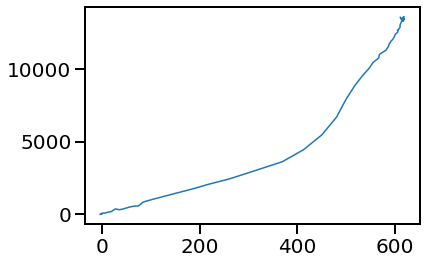

In [143]:
newlist = []
for i in strains_list[0][0]:
    newlist.append(i)

plt.plot(Eng_stress, newlist)

In [152]:
###strains_list[peak][cake][steps]

print(len(strains_list))
print(len(strains_list[0]))
print(len(strains_list[0][0]))


strains_list2 = []


for peak in range(len(strains_list)): #3
    for cake in range(len(strains_list[peak])): #36
        tmp = [] #generate 36 tmp lists
        
        for i in range(len(strains_list[peak][cake])): #58
            newlist = []
            
            for strain in strains_list[peak][cake]:
                
                newlist.append(strain)
        tmp.append(newlist)
    strains_list2.append(tmp)

print(len(strains_list2), len(strains_list2[0]), len(strains_list2[0][0]))

3
36
58
3 1 58


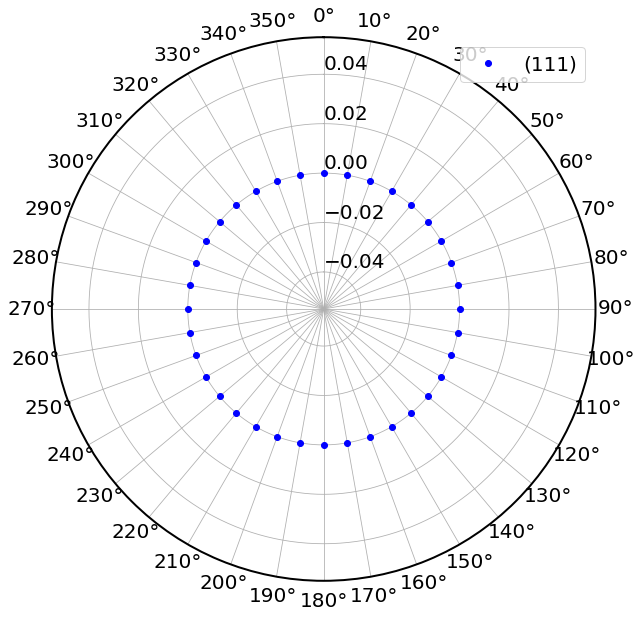

In [144]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = plt.subplot(111, projection='polar')
ax.plot(pp_range, strain_111_c0_s0, 'bo', label = '(111)')
ax.legend()
ax.set_rlabel_position(0)  # Move radial labels away from plotted line
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N', offset=0)
ax.set_xticks(np.pi/180. * np.linspace(0, 360, 36, endpoint=False))
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = plt.subplot(111, projection='polar')
ax.plot(pp_range, S2_pk_29deg, label = '(10-10)')
ax.plot(pp_range, S2_pk_33deg, label = '(01-11)')
ax.plot(pp_range, S2_pk_50deg, label = '(11-20)')
ax.legend()
ax.set_title("S2 Pk Max Intensity", va='bottom')
ax.set_rlabel_position(0)  # Move radial labels away from plotted line
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N', offset=0)
ax.set_xticks(np.pi/180. * np.linspace(0, 360, 36, endpoint=False))
plt.show()

In [ ]:
num_plots = len(flat_pk_intys)
fig, ax = plt.subplots(num_plots, figsize=(6, 400), subplot_kw=dict(projection='polar'))

for i in range(num_plots):
    for j in range(len(flat_pk_intys[i])):

        ax[i].plot(pp_range_deg, flat_pk_intys[i][j], label=j+1)
        ax[i].legend(loc=(1,1))
        title = 'S2_Step_' + str(i) + 'Pk Max Intensity'
        ax[i].set_title(title, va='bottom')
        ax[i].set_rlabel_position(0)  # Move radial labels away from plotted line
        ax[i].set_rmax(450000)
        ax[i].set_theta_direction(-1)
        ax[i].set_theta_zero_location('N', offset=0.0)
        ax[i].set_xticks(np.pi/180. * np.linspace(0, 360, 36, endpoint=False))